Версия тетрадки от Vitalii Pianykh

In [ ]:
## ## - мои комментарии, вопросы

In [ ]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'7.1.2'

In [ ]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
# ИСПРАВЛЕНИЕ: к сожалению этот код не работает у меня на коллабе
# плюс что-то намудрено с именами в репозитории pytorch
  
# установка подходящей версии torch

#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.5.0%2B{platform}-linux_x86_64.whl torchvision
#import torch

ERROR: torch-1.5.0+cp36-cp36m-linux_x86_64.whl is not a valid wheel filename.


In [ ]:
## а надо это? Не запускается
# ИСПРАВЛЕНИЕ:
# Вручную ищем и устанавливаем подходящуюю версию 
# https://download.pytorch.org/whl/torch_stable.html 
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

ERROR: torch-1.5.0+cu101-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
# ВНИМАНИЕ: мы это уже сделали вначале ноутбука

# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#import PIL
#print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/




---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [ ]:
# ИСПРАВЛЕНИЕ
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun May 22 07:10:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
## использовал для первых двух вариантов
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    ## наследуемся от torch.utils.data.Dataset
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

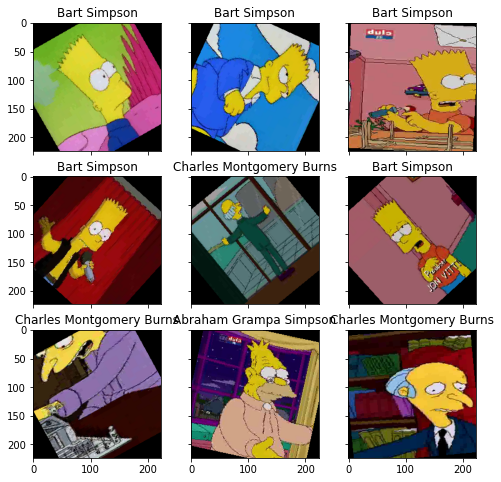

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
## использовал для первых двух вариантов
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    ## было: val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            ## добавил model.eval(), model.train()
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            model.train()
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
## с третьего варианта добавил шедулер и регуляризацию
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        ## добавим параметров в оптимизатор: регуляризацию, lr.
        opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
        ## шедулер, возможно, слишом резво уполовинивающий lr вдвое на эпоху
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.6)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            ## добавил model.eval(), model.train()
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            model.train()
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            ## изменяем learning rate после каждой эпохи
            scheduler.step()
            print(scheduler.get_lr())

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
## что это?
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

№1. Исходная модель в этом ноутбуке

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=4)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.0507577346691592


epoch:  20%|██        | 1/5 [02:21<09:26, 141.66s/it]


Epoch 001 train_loss: 2.0508     val_loss 1.3788 train_acc 0.4444 val_acc 0.6175
loss 1.1148181626184872


epoch:  40%|████      | 2/5 [04:46<07:10, 143.61s/it]


Epoch 002 train_loss: 1.1148     val_loss 1.1014 train_acc 0.6934 val_acc 0.7188
loss 0.7687193595645687


epoch:  60%|██████    | 3/5 [07:08<04:46, 143.01s/it]


Epoch 003 train_loss: 0.7687     val_loss 0.9437 train_acc 0.7854 val_acc 0.7574
loss 0.5664691594201233


epoch:  80%|████████  | 4/5 [09:35<02:24, 144.49s/it]


Epoch 004 train_loss: 0.5665     val_loss 0.9651 train_acc 0.8360 val_acc 0.7682
loss 0.43010716307608027


epoch: 100%|██████████| 5/5 [12:04<00:00, 144.97s/it]


Epoch 005 train_loss: 0.4301     val_loss 0.9728 train_acc 0.8741 val_acc 0.7717


In [ ]:
## сохраню веса на всякий случай
torch.save(simple_cnn.state_dict(), '/content/gdrive/My Drive/simple_cnn_state_dict.pth')

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
## val_acc имело другой формат из-за моей невнимательности
val_acc = tuple([i.cpu().numpy().item() for i in val_acc])
val_acc

(0.6175009552923194,
 0.7187619411539932,
 0.757355750859763,
 0.7682460833014902,
 0.7716851356515093)

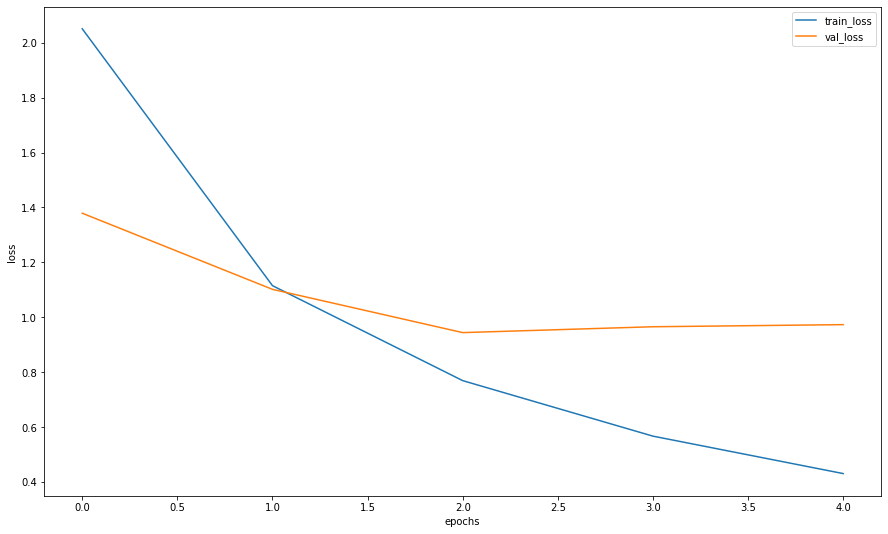

In [ ]:
## лоссы
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

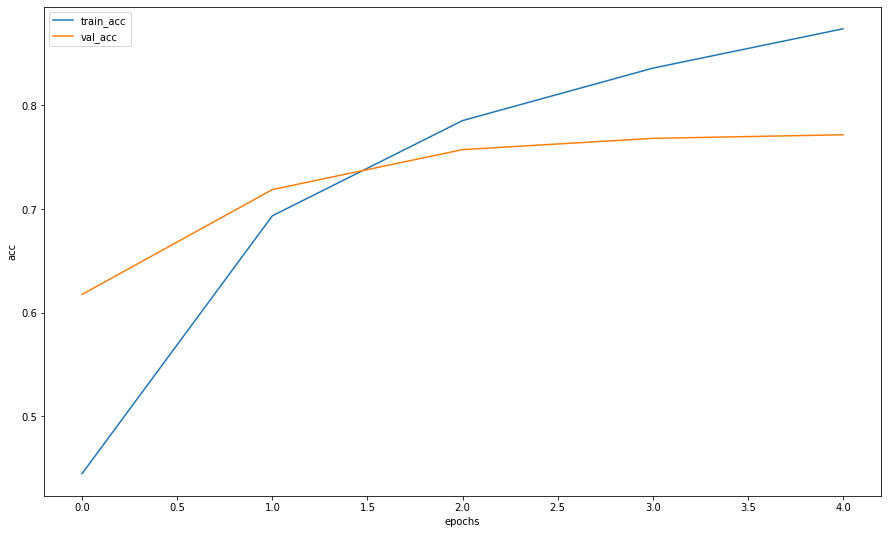

In [ ]:
## точность
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Результат на Каггле - 0.83103

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
## проверяем одну рандомную картинку?
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
## TODO вывести true_label, probs_im?
true_label, probs_im

(0, array([[9.4512606e-01, 7.6325504e-16, 1.8531028e-14, 9.2732853e-12,
         6.6908854e-07, 9.9430785e-22, 2.6767737e-09, 1.7918859e-15,
         1.6904935e-18, 6.5827213e-12, 8.7159392e-18, 1.1427214e-08,
         1.5590245e-20, 2.8619746e-14, 2.8220746e-17, 5.4871567e-02,
         1.8811733e-13, 9.5899511e-10, 1.6733875e-06, 4.8062796e-18,
         1.2044799e-08, 1.9389448e-10, 1.4667173e-09, 1.1470259e-11,
         1.6853309e-09, 1.3895125e-10, 1.5814777e-16, 7.7696161e-10,
         4.3695007e-08, 1.6049121e-09, 9.3143961e-15, 1.3051208e-12,
         1.5002220e-10, 2.7942392e-13, 1.0154398e-14, 5.3383740e-14,
         1.8987204e-14, 8.4804390e-14, 4.2287842e-16, 2.8403193e-22,
         1.0458787e-17, 1.4383510e-13]], dtype=float32))

In [ ]:
## проверяем 20 рандомных картинок?
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
## TODO вывести actual_labels, preds_class?
actual_labels, preds_class

([0, 4, 4, 6, 6, 6, 4, 0, 0, 4, 6, 3, 0, 6, 4, 6, 0, 4, 6, 6],
 ['abraham_grampa_simpson',
  'bart_simpson',
  'bart_simpson',
  'charles_montgomery_burns',
  'charles_montgomery_burns',
  'charles_montgomery_burns',
  'bart_simpson',
  'abraham_grampa_simpson',
  'abraham_grampa_simpson',
  'bart_simpson',
  'charles_montgomery_burns',
  'marge_simpson',
  'abraham_grampa_simpson',
  'charles_montgomery_burns',
  'bart_simpson',
  'charles_montgomery_burns',
  'abraham_grampa_simpson',
  'bart_simpson',
  'charles_montgomery_burns',
  'moe_szyslak'])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class)
## не сравниваются числа со строками )

ValueError: ignored

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

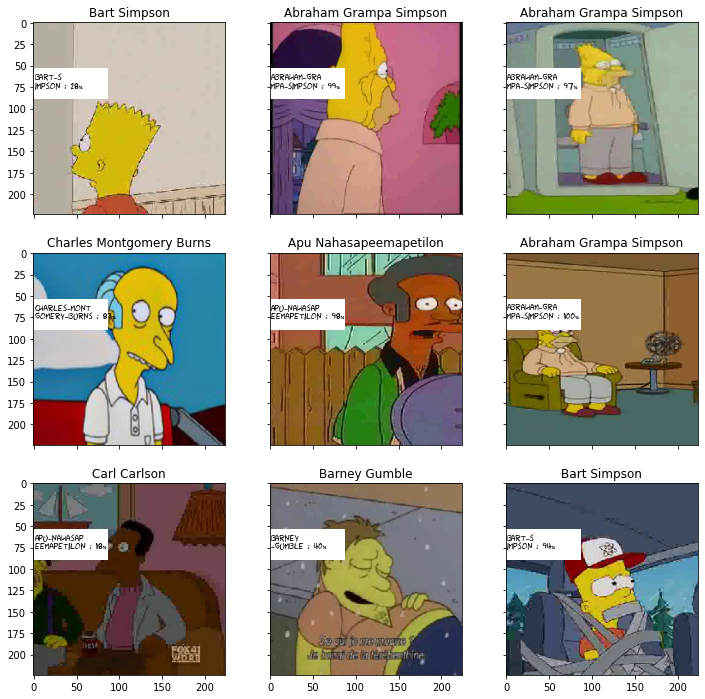

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске

In [ ]:
! ls 

characters_illustration.png  sample_data		testset
gdrive			     sample_submission.csv	train
label_encoder.pkl	     simple_cnn_state_dict.pth


In [ ]:
# ЗДЕСЬ что-то не работает. Не понятно зачем читайют лейблы 
#import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
#my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
#my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


________
____________
_______


Есть ли у нас план, мистер Фикс?

1. Кто же так строит нейронные сети? А где пулинги (## они же есть) и батч нормы? Надо добавлять
2. Учим дольше
3. изменяем гиперпараметры сети
4. learning rate, batch size, нормализация картинки и вот это всё
5. Данных не очень много, можно их аугументировать и доучититься на новом датасете ( который уже будет состоять из, как пример аугументации, перевернутых изображений)
- Ну разве Адам наше все? adamW для практика, статейка для любителей (очень хороший анализ), наши эксперименты для заинтересованных.
- Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и готовые скачать).
- Стоит подумать об ансамблях

№2. Добавим в сеть слоев нормализации, полносвязных слоев в классификатор

In [ ]:
# Очень простая сеть 2
class SimpleCnn2(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 512),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.Linear(128, n_classes)
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn_2 = SimpleCnn2(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn_2)

we will classify :42
SimpleCnn2(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn_2, epochs=5, batch_size=4)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.331700833578521


epoch:  20%|██        | 1/5 [02:43<10:53, 163.37s/it]


Epoch 001 train_loss: 2.3317     val_loss 1.5466 train_acc 0.3712 val_acc 0.5850
loss 1.6548711478233686


epoch:  40%|████      | 2/5 [05:25<08:07, 162.61s/it]


Epoch 002 train_loss: 1.6549     val_loss 1.1992 train_acc 0.5458 val_acc 0.6806
loss 1.3418697491729554


epoch:  60%|██████    | 3/5 [08:03<05:21, 160.70s/it]


Epoch 003 train_loss: 1.3419     val_loss 0.9936 train_acc 0.6338 val_acc 0.7272
loss 1.1303773245947613


epoch:  80%|████████  | 4/5 [10:40<02:39, 159.13s/it]


Epoch 004 train_loss: 1.1304     val_loss 0.8586 train_acc 0.6921 val_acc 0.7696
loss 0.9839878925218721


epoch: 100%|██████████| 5/5 [13:22<00:00, 160.55s/it]


Epoch 005 train_loss: 0.9840     val_loss 0.7608 train_acc 0.7306 val_acc 0.7990


In [ ]:
## сохраню веса на всякий случай
torch.save(simple_cnn_2.state_dict(), '/content/gdrive/My Drive/simple_cnn_2_state_dict.pth')

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

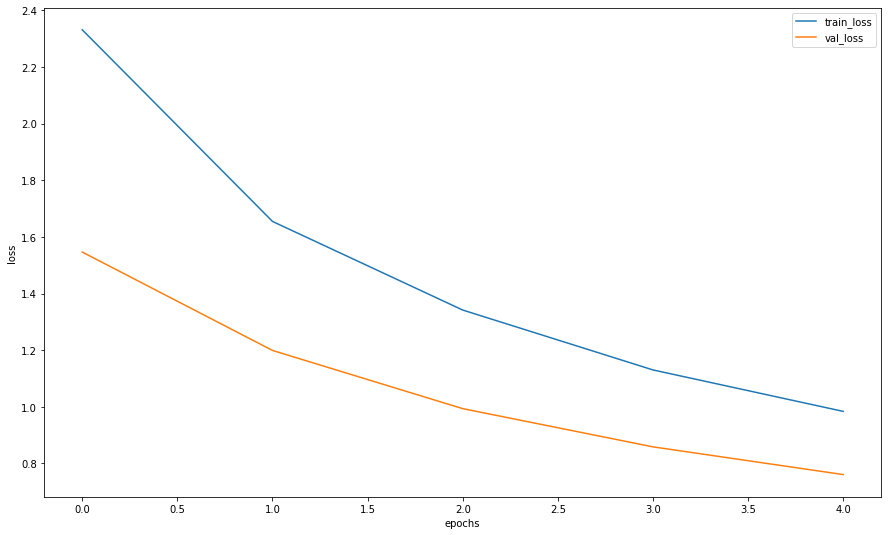

In [ ]:
## лоссы
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

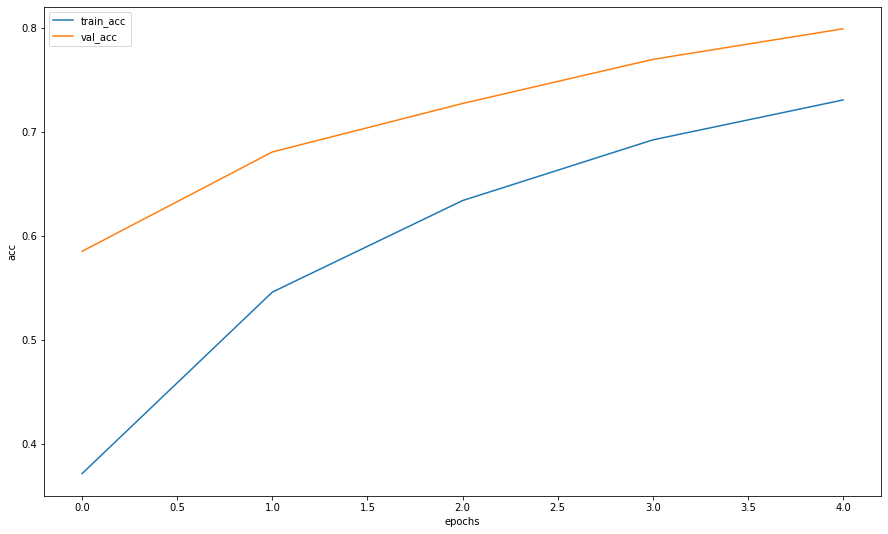

In [ ]:
## точность
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
## явно недообучился

In [ ]:
simple_cnn_2.load_state_dict(torch.load('/content/gdrive/My Drive/simple_cnn_2_state_dict.pth'))

<All keys matched successfully>

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn_2, epochs=10, batch_size=4)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8616905248010794


epoch:  10%|█         | 1/10 [02:41<24:13, 161.47s/it]


Epoch 001 train_loss: 0.8617     val_loss 0.7202 train_acc 0.7610 val_acc 0.8128
loss 0.7585647600789021


epoch:  20%|██        | 2/10 [05:17<21:05, 158.19s/it]


Epoch 002 train_loss: 0.7586     val_loss 0.6708 train_acc 0.7887 val_acc 0.8259
loss 0.6783285340404673


epoch:  30%|███       | 3/10 [07:52<18:17, 156.76s/it]


Epoch 003 train_loss: 0.6783     val_loss 0.6521 train_acc 0.8094 val_acc 0.8313
loss 0.6058840038496245


epoch:  40%|████      | 4/10 [10:27<15:36, 156.08s/it]


Epoch 004 train_loss: 0.6059     val_loss 0.6365 train_acc 0.8285 val_acc 0.8424
loss 0.5654229716163731


epoch:  50%|█████     | 5/10 [13:02<12:58, 155.70s/it]


Epoch 005 train_loss: 0.5654     val_loss 0.6259 train_acc 0.8402 val_acc 0.8403
loss 0.5112860448054862


epoch:  60%|██████    | 6/10 [15:37<10:22, 155.55s/it]


Epoch 006 train_loss: 0.5113     val_loss 0.5862 train_acc 0.8534 val_acc 0.8538
loss 0.46052697700630624


epoch:  70%|███████   | 7/10 [18:12<07:46, 155.41s/it]


Epoch 007 train_loss: 0.4605     val_loss 0.6150 train_acc 0.8666 val_acc 0.8538
loss 0.42821528730266095


epoch:  80%|████████  | 8/10 [20:47<05:10, 155.32s/it]


Epoch 008 train_loss: 0.4282     val_loss 0.6113 train_acc 0.8746 val_acc 0.8529
loss 0.4114412621803397


epoch:  90%|█████████ | 9/10 [23:23<02:35, 155.28s/it]


Epoch 009 train_loss: 0.4114     val_loss 0.6052 train_acc 0.8799 val_acc 0.8536
loss 0.3802138235394003


epoch: 100%|██████████| 10/10 [25:58<00:00, 155.83s/it]


Epoch 010 train_loss: 0.3802     val_loss 0.6232 train_acc 0.8892 val_acc 0.8548


In [ ]:
## сохраню веса на всякий случай
torch.save(simple_cnn_2.state_dict(), '/content/gdrive/My Drive/simple_cnn_2_state_dict.pth')

In [ ]:
loss2, acc2, val_loss2, val_acc2 = zip(*history)

In [ ]:
loss, acc, val_loss, val_acc \
        = loss + loss2, acc + acc2, val_loss + val_loss2, val_acc + val_acc2

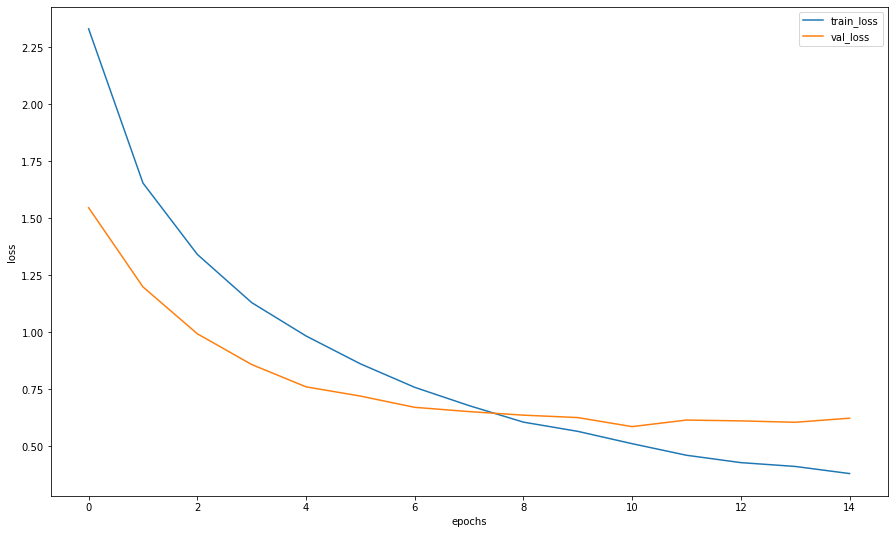

In [ ]:
## лоссы
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

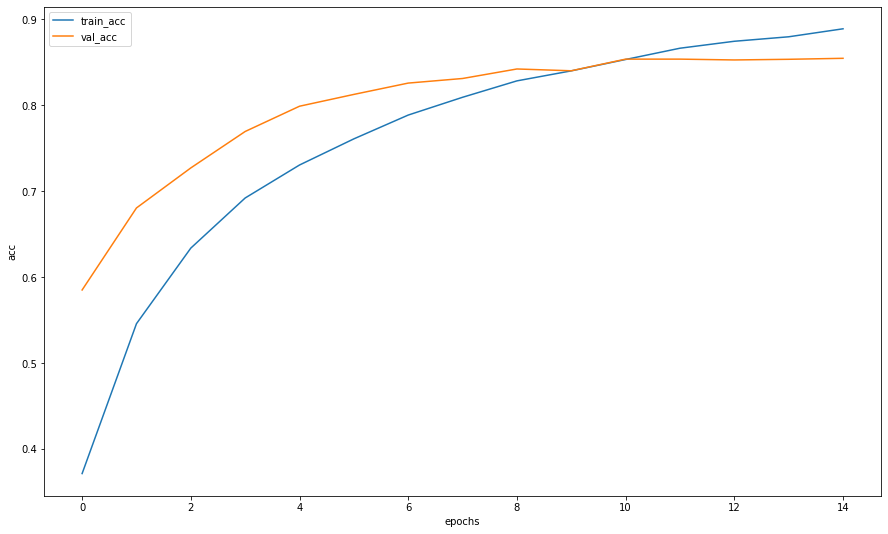

In [ ]:
## точность
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Результат на каггле - 0.93836

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn_2, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline_2.csv', index=False)
# файл появится у вас на гугл диске

№3. Используем ту же самую нейросеть simple_cnn_2  
В функции train добавил:
- регуляризацию в оптимизатор;
- scheduler.

In [ ]:
simple_cnn_2.load_state_dict(torch.load('/content/gdrive/My Drive/simple_cnn_2_state_dict.pth'))

NameError: ignored

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn_2, epochs=10, batch_size=4)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 342.6038464410448


epoch:  10%|█         | 1/10 [04:33<41:04, 273.86s/it]


Epoch 001 train_loss: 342.6038     val_loss 3.4471 train_acc 0.0743 val_acc 0.1034
loss 3.2168864042366057


epoch:  20%|██        | 2/10 [09:06<36:23, 272.88s/it]


Epoch 002 train_loss: 3.2169     val_loss 3.1749 train_acc 0.0893 val_acc 0.1074
loss 3.1528240482293386


epoch:  30%|███       | 3/10 [13:37<31:45, 272.14s/it]


Epoch 003 train_loss: 3.1528     val_loss 3.1452 train_acc 0.0981 val_acc 0.0904
loss 3.120252908753076


epoch:  40%|████      | 4/10 [18:11<27:17, 272.85s/it]


Epoch 004 train_loss: 3.1203     val_loss 3.1387 train_acc 0.1046 val_acc 0.1074
loss 3.1375221500078414


epoch:  50%|█████     | 5/10 [22:46<22:49, 273.81s/it]


Epoch 005 train_loss: 3.1375     val_loss 3.1333 train_acc 0.1017 val_acc 0.1074
loss 3.124245179657025


epoch:  60%|██████    | 6/10 [27:22<18:17, 274.40s/it]


Epoch 006 train_loss: 3.1242     val_loss 3.1241 train_acc 0.1062 val_acc 0.1074
loss 3.117660820199408


epoch:  70%|███████   | 7/10 [31:55<13:41, 273.88s/it]


Epoch 007 train_loss: 3.1177     val_loss 3.1159 train_acc 0.1069 val_acc 0.1074


epoch:  70%|███████   | 7/10 [31:59<13:42, 274.20s/it]


KeyboardInterrupt: ignored

In [ ]:
'''
Epoch 010 train_loss: 0.3802     val_loss 0.6232 train_acc 0.8892 val_acc 0.8548
'''

In [ ]:
## сохраню веса на всякий случай
torch.save(simple_cnn_2.state_dict(), '/content/gdrive/My Drive/simple_cnn_2_state_dict_3.pth')

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
## лоссы
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
## точность
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn_2, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline_2.csv', index=False)
# файл появится у вас на гугл диске

In [ ]:
simple_cnn_2.load_state_dict(torch.load('/content/gdrive/My Drive/simple_cnn_2_state_dict.pth'))

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn_2, epochs=10, batch_size=4)

In [ ]:
## сохраню веса на всякий случай
torch.save(simple_cnn_2.state_dict(), '/content/gdrive/My Drive/simple_cnn_2_state_dict_3.pth')

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
## лоссы
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
## точность
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn_2, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline_2.csv', index=False)
# файл появится у вас на гугл диске